# Compare models for visual proprioception

Compares regression models for visual proprioception, by running them on specific test data, and creating comparison graphs that put all of them onto the graphs. 

Each configuration is specified by a run of type visual_proprioception.

In [1]:
import sys
sys.path.append("..")
from settings import Config

import pathlib
from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
import math
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

# from behavior_cloning.demo_to_trainingdata import BCDemonstration
from sensorprocessing import sp_conv_vae, sp_propriotuned_cnn
# from robot.al5d_position_controller import RobotPosition

from visual_proprioception.visproprio_helper import load_demonstrations_as_proprioception_training
from visual_proprioception.visproprio_models import VisProprio_SimpleMLPRegression
from visproprio_helper import get_visual_proprioception_sp

# Move data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading pointer config file: C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
Loading machine-specific config file: G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml


In [2]:
experiment = "visual_proprioception"

# the lead run is the one that will provide the test data.
# also the directory of this run is where the graphs will be saved.

leadrun = "vp_mpl_conv_vae_1"
# the runs considered in the experiment 
runs = ["vp_mpl_conv_vae_1", "vp_mpl_propriotuned_cnn_1", "vp_mpl_aruco_1"]

# now load them
leadexp = Config().get_experiment(experiment, leadrun)

exps = []
sps = [ ]
models = [ ]
for run in runs:
    exp = Config().get_experiment(experiment, run)
    exps.append(exp)

    #if exp["sensor_processing"] == "ConvVaeSensorProcessing":
    #    spexp = Config().get_experiment(
    #        exp['sp_experiment'], exp['sp_run'])
    #    sp = sp_conv_vae.ConvVaeSensorProcessing(spexp)
    #elif exp['sensor_processing']=="VGG19ProprioTunedSensorProcessing":
    #    spexp = Config().get_experiment(exp['sp_experiment'], exp['sp_run'])
    #    sp = sp_propriotuned_cnn.VGG19ProprioTunedSensorProcessing(spexp, device)
    #else:
    #    raise Exception('Unknown sensor processing {exp["sensor_processing"]}')
    # spexp = Config().get_experiment(exp['sp_experiment'], exp['sp_run'])
    sp = get_visual_proprioception_sp(exp, device)
    sps.append(sp)
    model = VisProprio_SimpleMLPRegression(exp)
    modelfile = pathlib.Path(exp["data_dir"], 
                            exp["proprioception_mlp_model_file"])
    model.load_state_dict(torch.load(modelfile))
    models.append(model)


No system dependent experiment file
 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\vp_mpl_conv_vae_1_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: visual_proprioception/vp_mpl_conv_vae_1 successfully loaded
No system dependent experiment file
 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\vp_mpl_conv_vae_1_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: visual_proprioception/vp_mpl_conv_vae_1 successfully loaded
Configuration for experiment: sensorprocessing_conv_vae/proprio_128 successfully loaded
No system dependent experiment file
 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\vp_mpl_propriotuned_cnn_1_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: visual_proprioception/vp_mpl_propriotuned_cnn_1 successfully loaded
No

C:\Users\lboloni\AppData\Local\Temp\ipykernel_112276\17420594.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelfile))
c:\Users\lbol

No system dependent experiment file
 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\vp_mpl_aruco_1_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: visual_proprioception/vp_mpl_aruco_1 successfully loaded
Configuration for experiment: sensorprocessing_aruco/aruco_128 successfully loaded


In [3]:
task = leadexp["proprioception_testing_task"]
proprioception_input_file = pathlib.Path(
    leadexp["data_dir"], leadexp["proprioception_test_input_file"])
proprioception_target_file = pathlib.Path(
    leadexp["data_dir"], leadexp["proprioception_test_target_file"])
tr = load_demonstrations_as_proprioception_training(
    sp, task, proprioception_input_file, proprioception_target_file)

targets = tr["targets"]
print(f"There are {targets.shape[0]} data points")

There are 1040 data points


Iterate throuh all the components. The thing with it though is that this will get the test data from the components, not from the lead exp.

FIXME: maybe I could just write a function that runs a particular proprioceptor on a whole task and returns the y, and then just call that. 

In [4]:
no_from = 0
no_to = targets.shape[0]

ypreds = []

for exp, sp, model in zip(exps, sps, models):
    task = exp["proprioception_testing_task"]
    proprioception_input_file = pathlib.Path(
        exp["data_dir"], exp["proprioception_test_input_file"])
    proprioception_target_file = pathlib.Path(
        exp["data_dir"], exp["proprioception_test_target_file"])
    tr = load_demonstrations_as_proprioception_training(
        sp, task, proprioception_input_file, proprioception_target_file)
    inputs = tr["inputs"] 
    ypred = []
    y = []
    t = []
    with torch.no_grad():
        for i in range(no_from, no_to):
            x = inputs[i]
            predictions = model(torch.unsqueeze(x, dim=0))
            # append the data 
            t.append(i)
            y.append(targets[i].numpy())
            ypred.append(predictions[0].numpy())
    ypred = np.array(ypred)
    ypreds.append(ypred)            
    y = np.array(y)
    t = np.array(t)

At this point, we should have the ypreds, the y and the t and we can plot them.

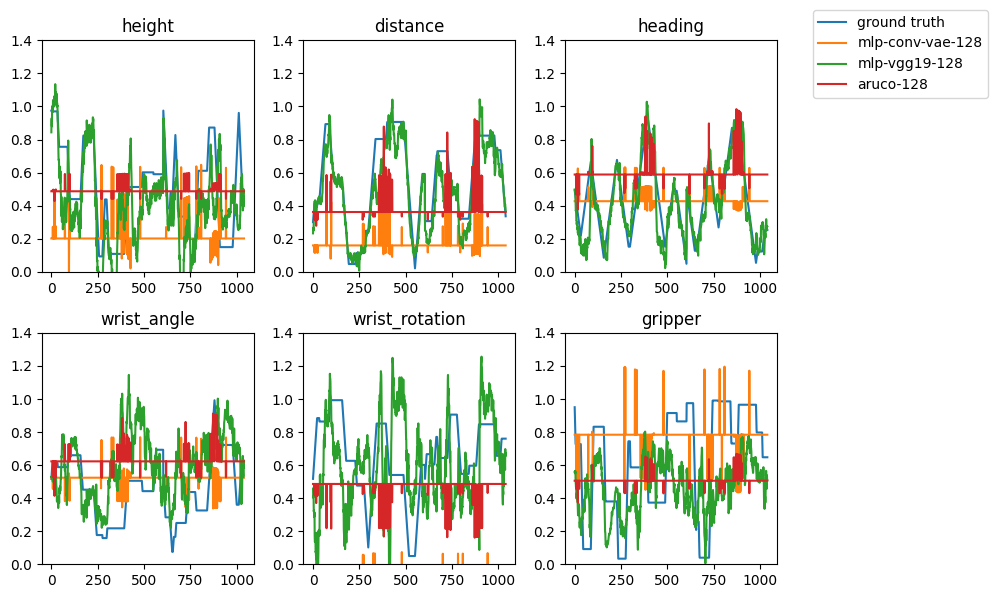

In [5]:
fig, axs = plt.subplots(2,3, figsize=(8, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3] 
    ax.set_ylim(0, 1.4)
    ax.plot(t, y[:,i], label="ground truth")
    for ypred, exp in zip(ypreds,exps):
        # fixme, fix the label to the name in the exp
        ax.plot(t, ypred[:,i], label=exp["name"])
    if i==0:
        fig.legend(bbox_to_anchor=(1.25, 1))
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "comparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

### Comparing the average accuracy
Create a graph that is comparing the average accuracy. 

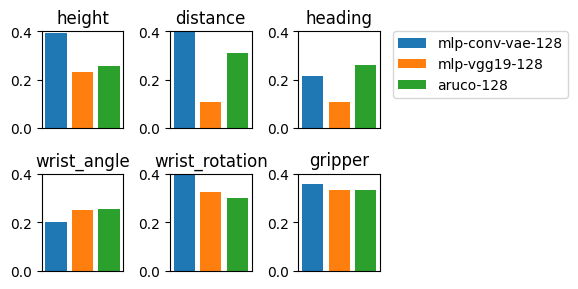

In [11]:
fig, axs = plt.subplots(2,3, figsize=(4, 3))

for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3] 
    ax.set_ylim(0, 0.4)
    # ax.plot(t, y[:,i], label="y")
    bars = []
    names = []
    for ypred, exp in zip(ypreds,exps):
        ## FIXME: some kind of different plot
        # error = avg(y[:,i], ypred[:,i])
        error = math.sqrt(np.mean((y[:,i]- ypred[:,i]) ** 2))
        br = ax.bar(exp["name"], error)
        bars.append(br)
        names.append(exp["name"])
    # Remove x-axis labels if desired
    ax.set_xticks([])        
    if i==0:
        fig.legend(bars, names, bbox_to_anchor=(1.45, 0.9), ncol=1) 
    fig.tight_layout()
    ax.set_title(titles[i])

fig.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')